# Imports

In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np

# Enabling the gpu to speed up training process

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Setup

basic knowledge gained from https://www.tensorflow.org/tutorials/images/transfer_learning

and https://www.youtube.com/channel/UCHXa4OpASJEwrHrLeIzw7Yg

In [4]:
#type the path to the FinalImageFolder of the MultiClassTestingFolder into here
PATH = 'C:/Users/User/OneDrive/Desktop/DeepLearningStuff/Images/MultiClassTestingFolder/FinalImageFolder'

train_directory = os.path.join(PATH, 'train')
validation_directory = os.path.join(PATH, 'validation')
test_directory = os.path.join(PATH, 'test')

In [5]:
# batchsize is the number of training examples utilized in one iteration
BATCH_SIZE = 32

# imgsize is the size of an image
# this is needed, because the images have to be of the same size
IMG_SIZE_WIDTH = 256
IMG_SIZE_HEIGHT = 256
IMG_SIZE = (IMG_SIZE_WIDTH, IMG_SIZE_HEIGHT)
num_classes = 5

In [6]:
#setting up the train and the validation dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(train_directory,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_directory,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

test_dataset = tf.keras.utils.image_dataset_from_directory(test_directory,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 7000 files belonging to 5 classes.
Found 3000 files belonging to 5 classes.
Found 50 files belonging to 5 classes.


# Preprocessing

In [7]:
# the lower the values, the faster it will work
# thus we want to scale the images from a range of 0-255 to 0-1

train_dataset = train_dataset.map(lambda x,y: (x/255, y))
validation_dataset = validation_dataset.map(lambda x,y: (x/255, y))
test_dataset = test_dataset.map(lambda x,y: (x/255, y))

In [8]:
data_iterator = train_dataset.as_numpy_iterator()

In [9]:
batch = data_iterator.next()

In [10]:
def indexToClassName(index):
    if index == 0:
        return "Base Gesture"
    elif index == 1:
        return "Fist Gesture"
    elif index == 2:
        return "Ok Gesture"
    elif index == 3:
        return "Peace Gesture"
    elif index == 4:
        return "Rock On Gesture"

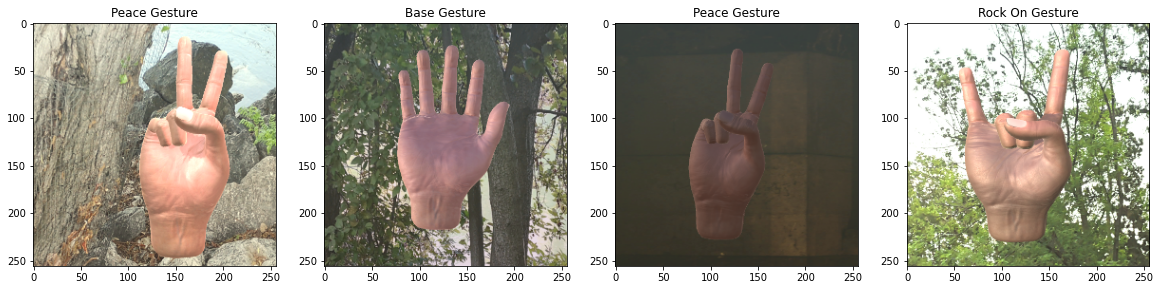

In [11]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(indexToClassName(batch[1][idx]))

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Build Neural Network Model

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, RandomFlip, RandomRotation, RandomZoom, Rescaling, Activation

In [14]:
model = Sequential([
  RandomRotation(0.1, input_shape=(IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH, 3)),
  RandomZoom(0.1),
  Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH, 3)),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Dropout(0.5),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes)
])

In [15]:
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation (RandomRota  (None, 256, 256, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0

# Training the Neural Network

In [17]:
logdir='logs'

In [18]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
earlystopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [ ]:
hist = model.fit(train_dataset, epochs=100, validation_data=validation_dataset, callbacks=[tensorboard_callback, earlystopping_callback])

Epoch 1/100


# Performance Graphs

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Testing a single image

In [ ]:
import cv2 as opencv

In [ ]:
img = opencv.imread('Images/MultiClassTestingFolder/GestureTestingFolder/test/PeaceGesture/IMG_20220612_060548.jpg')
img = opencv.cvtColor(img, opencv.COLOR_BGR2RGB)
plt.imshow(img/255)
plt.show()

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize, 0))

In [ ]:
yhat

In [ ]:
maxValueClass = 0
maxValue = float('-inf')
for i in range(len(yhat[0])):
    if(yhat[0][i] > maxValue):
        maxValue = yhat[0][i]
        maxValueClass = i
        
print("predicted class is " + indexToClassName(maxValueClass) + " with a value of " + str(maxValue))

# Testing whole folder

In [ ]:
imageCount = 0
correctCount = 0
falseCount = 0

currBatch = 0;

confusionmatrix = []
for i in range(num_classes):
    confusionmatrix.append([])
    for j in range(num_classes):
        confusionmatrix[i].append(0)

for batch in test_dataset.as_numpy_iterator():
    for idx, img in enumerate(batch[0]):
        print("image number " + str(BATCH_SIZE * currBatch + idx))
        plt.imshow(img)
        plt.show()

        yhat = model.predict(np.expand_dims(img, 0))
        print(yhat)
        
        maxValueClass = 0
        maxValue = float('-inf')
        for i in range(len(yhat[0])):
            if(yhat[0][i] > maxValue):
                maxValue = yhat[0][i]
                maxValueClass = i
                
        print("predicted class is " + indexToClassName(maxValueClass) + " with a value of " + str(maxValue))

        if(maxValueClass == batch[1][idx]):
            # predicted as handMissing but is handExists
            print("Correct: predicted as " + indexToClassName(maxValueClass) + " and is " + indexToClassName(batch[1][idx]))
            correctCount += 1
        else:
            # predicted as handMissing and is handMissing
            print("False: predicted as " + indexToClassName(maxValueClass) + " but is " + indexToClassName(batch[1][idx]))
            falseCount += 1
        
        confusionmatrix[batch[1][idx]][maxValueClass] += 1
            
        imageCount += 1
        print("______________")
    currBatch += 1
    
print("Amount categorized: " + str(imageCount))
print("Correctly categorized: " + str(correctCount))
print("Falsely categorized: " + str(falseCount))
print("Ratio: " + str(correctCount / imageCount))

normalDetectionRatio = correctCount / imageCount

In [ ]:
normalDetectionRatio

In [ ]:
confusionmatrix

In [ ]:
display_labels = []

for i in range(num_classes):
    display_labels.append(indexToClassName(i))

In [ ]:
import seaborn as sns

sns.set(rc = {'figure.figsize':(10,8)})

ax = sns.heatmap(confusionmatrix, fmt='', cmap='Blues', vmin = 0, vmax = 10)

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(display_labels)
ax.yaxis.set_ticklabels(display_labels)

## Display the visualization of the Confusion Matrix.
plt.show()